Shape of data:
X shape: (8159, 14)
y shape: (8159,)
0.8736487453253485
0.8519061565276331
0.8484311938025053

Average MSE across folds: 49286.6205

Final MSE on full dataset: 19348.0052
R^2: 0.9443


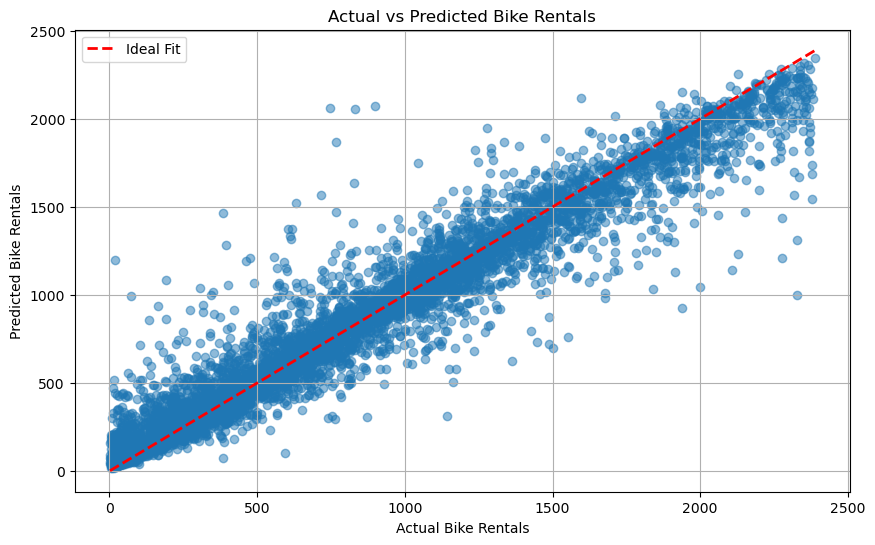

In [5]:
# Ok, this one uses HistGradientBoostingRegressor which works better and I think uses histograms? IDK mostly
# copied from the og GradientBoostedRegression which is in the next cell

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
standardizedData = pd.read_csv('ProcessedData.csv')

X = standardizedData.drop('Rented Bike Count', axis=1) #X = feature matrix
y = standardizedData['Rented Bike Count'] #y = target variable

print("Shape of data:")
print("X shape:", X.shape)
print("y shape:", y.shape)


poly = PolynomialFeatures(degree=2, include_bias=False) 
X_poly = poly.fit_transform(X) #adding polynomial features to aid learning (iirc she said this helps in lecture)

#n_estimators = number of trees? I think? idk I did a lot of googling and kind of mashed stuff together
#increasing n_estimators increases r^2 significantly
#also currently a pretty high learning rate (which seems to be working) haven't really experimented with that
def optimized_gradient_boosting(X, y, folds, learning_rate=0.1, n_estimators=30):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42) #split into folds for cross validation
    fold_mses = [] #just for documentation for the index of the best one
    models = []

    for train_index, val_index in kf.split(X): #loop through the folds
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train Random Forest regressor
        from sklearn.ensemble import RandomForestRegressor

        gbr = RandomForestRegressor()
        gbr.fit(X_train, y_train)

        # Predict and evaluate on the validation set
        y_pred = gbr.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        print(r2_score(y_val, y_pred))
        fold_mses.append(mse)
        models.append(gbr)

    avg_mse = np.mean(fold_mses)
    print(f"\nAverage MSE across folds: {avg_mse:.4f}")
    return models[np.argmin(fold_mses)]  # Return the best model

# Train and get the best model
best_model = optimized_gradient_boosting(X_poly, y, folds=3)

# Final predictions
predictions = best_model.predict(X_poly)

# Clip predictions to prevent negatives
#Did this bc I was getting a lot of negative predictions and it would be practically impossible to sell negative
#bikes (unless someone gave one to you I guess)
predictions = np.clip(predictions, 0, None) 

# Calculate MSE and R^2
final_mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)

print(f"\nFinal MSE on full dataset: {final_mse:.4f}")
print(f"R^2: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Bike Rentals')
plt.ylabel('Predicted Bike Rentals')
plt.title('Actual vs Predicted Bike Rentals')
plt.legend()
plt.grid(True)
plt.show()
